# Installing libraries:

In [1]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.layers import BatchNormalization
import keras
import os
import sys
import numpy as np
import json
import argparse
import scipy
import scipy.signal
import scipy.io.wavfile
import math
import time
import wave
from pylab import *
import array
from os.path import expanduser
from IPython.display import Audio, display
import soundfile as sf


rootdir_path = '/home/christosf/AttProtos/apnet'
sys.path.append(rootdir_path)
from apnet.datasets import MUSDB18Mixtures, MUSDB18Mixtures3

rootdir_path = '/home/christosf/AttProtos'
sys.path.append(rootdir_path)

from attprotos.layers import PrototypeReconstruction
from attprotos.losses import prototype_loss
from attprotos.model import AttProtos2
from attprotos.features import Openl3

# Features
from dcase_models.data.features import MelSpectrogram, STFT_Phase

from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.scaler import Scaler
from dcase_models.util.files import load_json, load_pickle
from dcase_models.util.files import mkdir_if_not_exists, save_pickle
from dcase_models.util.data import evaluation_setup
from dcase_models.model.container import KerasModelContainer
from dcase_models.data.feature_extractor import FeatureExtractor
from dcase_models.util.files import load_json

from keras.layers import Layer

import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


from keras.layers import Input, Lambda, Dense, Flatten, Multiply, Reshape, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import LeakyReLU, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from keras.regularizers import l1
import keras.backend as K

from dcase_models.model.container import KerasModelContainer
rootdir_path = '/home/christosf/AttProtos'
sys.path.append(rootdir_path)
from attprotos.losses import prototype_loss, dummy_loss
from attprotos.layers import PrototypeReconstruction

import tensorflow as tf

rootdir_path = '/home/christosf/AttProtos/xaudio-main'
sys.path.append(rootdir_path)
from xaudio.core import create_analyzer
from xaudio.models import yamnet, vggish, attprotos
import innvestigate.utils as iutils
import matplotlib.pyplot as plt
import innvestigate

import librosa
from librosa.feature.inverse import mel_to_stft
from librosa.util import nnls
import librosa.display

import essentia
import essentia.standard
from essentia.standard import *
from essentia.standard import OverlapAdd

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/christosf/anaconda3/envs/apnet2

## MUSDB18Mixtures dataset:

In [3]:
dataset = MUSDB18Mixtures('/home/christosf/AttProtos/datasets/MUSDB18Mixtures')
dataset_path = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures' 
#dataset.download()

dataset.generate_file_lists()

vocals_train = []
no_vocals_train = []
for item in dataset.file_lists['train']:
    class_ = dataset.file_to_classes[item]
    if class_ == 'vocals':
        vocals_train.append(item)
    if class_ == 'no_vocals':
        no_vocals_train.append(item)
        
vocals_test = []
no_vocals_test = []
for item in dataset.file_lists['test']:
    class_ = dataset.file_to_classes[item]
    if class_ == 'vocals':
        vocals_test.append(item)
    if class_ == 'no_vocals':
        no_vocals_test.append(item)
        
print(dataset.label_list)
print("train set:", len(dataset.file_lists['train']), "tracks in total", "(vocals:", len(vocals_train), ", ", "no_vocals:", len(no_vocals_train), ")" )
print("test set:", len(dataset.file_lists['test']), "tracks in total", "(vocals:", len(vocals_test), ", ", "no_vocals:", len(no_vocals_test), ")" )


['vocals', 'no_vocals']
train set: 2703 tracks in total (vocals: 1313 ,  no_vocals: 1390 )
test set: 1638 tracks in total (vocals: 796 ,  no_vocals: 842 )


# Setting up the model for analysis:

In [4]:
dataset_name = "MUSDB18Mixtures"
models_path = '/home/christosf/AttProtos/experiments'
dataset_path = './'
fold_name = "test"


model_folder = os.path.join(models_path, dataset_name, "AttProtos2")
parameters_file = os.path.join(model_folder, 'config.json')

with open(parameters_file, 'r') as f:
	params = json.load(f)

params_features = params['features']["MelSpectrogram"]

params_dataset = params['datasets'][dataset_name]
params_model = params['models']["AttProtos2"]


# Get and init dataset class
#dataset_path = os.path.join(dataset_path, params_dataset['dataset_path'])
#print(dataset_path)
#dataset = MUSDB18Mixtures(dataset_path)


# Get and init feature class
features = MelSpectrogram(**params_features)


scaler = Scaler(normalizer=params_model['normalizer'])
# Init data generator
data_gen_test = DataGenerator(
    dataset, features, folds=[fold_name],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=False, scaler=scaler
)


metrics = ['classification']

features_shape = features.get_shape()
n_frames_cnn = features_shape[1]
n_freq_cnn = features_shape[2]
n_classes = len(dataset.label_list)

print(dataset.label_list)
print(n_classes)
print(n_freq_cnn)
print(n_frames_cnn)
print('Features shape: ', features.get_shape(10.0))

model_container = AttProtos2(
    model=None, model_path=None, n_classes=n_classes,
    n_frames_cnn=n_frames_cnn, n_freq_cnn=n_freq_cnn,
    metrics=metrics, training=True,
    **params_model['model_arguments']
)

exp_folder = '/home/christosf/AttProtos/experiments/MUSDB18Mixtures/AttProtos2/test'


scaler_file = os.path.join(exp_folder, 'scaler.pickle')
scaler = load_pickle(scaler_file)

data_gen_test = DataGenerator(
    dataset, features, folds=[fold_name],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=False, scaler=scaler
)

data_gen_train = DataGenerator(
    dataset, features, folds=['train'],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

model = model_container.model

model.load_weights('/home/christosf/AttProtos/experiments/MUSDB18Mixtures/AttProtos2/test/best_weights.hdf5')


X, Y = data_gen_test.get_data()
print(model.outputs)

['vocals', 'no_vocals']
2
256
128


/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:285: FutureWarning: Pass sr=44100, n_fft=4096, n_mels=256 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sr, n_fft, mel_bands, **kwargs)
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/feature_extractor.py:358: FutureWarning: Pass size=462848 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode=self.pad_mode
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:322: FutureWarning: Pass size=581 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode='constant')
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/feature_extractor.py:372: FutureWarning: Pass frame_length=128, hop_length=64 as keyword args. From version 0

Features shape:  (8, 128, 256)
encoder x (?, 128, 256)
encoder y (?, 128, 256, 1)
Instructions for updating:
Colocations handled automatically by placer.
bool_mask1 shape (?, 128, 256, 32)
mask1 shape (?, 128, 256, 32)
1:deconv (?, ?, ?, 1)
2:deconv (?, 128, 256)
y encoder mask (?, 128, 256, 1)
alpha 1: (?, 32, 64, 15)
alpha 2: (?, 1, 64, 15)
alpha 3: (?, ?)
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'decoder/final_activation/Tanh:0' shape=(?, 128, 256) dtype=float32>, <tf.Tensor 'lc/Sum_1:0' shape=(?, 15) dtype=float32>, <tf.Tensor 'mse3/add:0' shape=() dtype=float32>]
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'decoder/final_activation/Tanh:0' shape=(?, 128, 256) dtype=float32>, <tf.Tensor 'lc/Sum_1:0' shape=(?, 15) dtype=float32>, <tf.Tensor 'mse3/add:0' shape=() dtype=float32>]


# ANALYSIS COMPARISON

In [1]:
# Code has been adapted from iNNvestigate and Xaudio libraries

In [6]:
class Analyzer:
    def __init__(self, analyzer, model, neuron_selection_mode):
        self.analyzer = innvestigate.create_analyzer(
            analyzer, model, neuron_selection_mode=neuron_selection_mode
        )

    def analyze(self, filename, index=None, **kwargs):
        inputs = filename
        if index is not None:
            analysis = self.analyzer.analyze(inputs, index, **kwargs)
        else:
            analysis = self.analyzer.analyze(inputs, **kwargs)
        return inputs, analysis


def create_analyzer(
    analyzer, model, neuron_selection_mode="max_activation"
):
    analysis = Analyzer(analyzer, model, neuron_selection_mode)
    return analysis

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

def plot_explanations(fig, axs, inputs, explanations):
    axs[0].imshow(inputs[0].T, origin="lower", vmax=np.amax(inputs), vmin=np.amin(inputs))
    plt.ylabel('mel filter index')
    axs[0].set_title("Input Mel Spectrogram")
    plt.ylabel('mel filter index')
    max_value = max(np.abs(np.amin(explanations)), np.abs(np.amax(explanations)))
    divnorm=colors.TwoSlopeNorm(vmin=-max_value, vcenter=0., vmax=max_value)
    im = axs[1].imshow(explanations[0][0].T, origin="lower")
    #im = axs[1].imshow(explanations[0][0].T, origin="lower", cmap="coolwarm", norm=divnorm)
    axs[1].set_title(label_list[class_most_activated[0]])
    
    im = axs[2].imshow(explanations[1][0].T, origin="lower")
    axs[2].set_title(label_list[class_most_activated[1]])

    
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.savefig('saliency_maps_MUSDB18Mixtures_{}'.format(instance), dpi=300)

In [10]:
instance = 290
#129
#instance = 519
melspec = X[instance]
label_list = dataset.label_list

analysis = [
    "lrp.sequential_preset_a",
    "lrp.sequential_preset_a_flat",
    "lrp.alpha_1_beta_0",
    "lrp.alpha_1_beta_0_IB",
    "lrp.alpha_2_beta_1_IB",
    "lrp.flat",
    "lrp.z",
    "gradient",
    "smoothgrad"
]

analyzers = {}
for a in analysis:
    analyzers[a] = create_analyzer(a, model, neuron_selection_mode='index')

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.advanced_activations.ReLU object at 0x7f67e9e38d30>, <keras.layers.advanced_activations.ReLU object at 0x7f67e9e705f8>, <keras.layers.advanced_activations.ReLU object at 0x7f67e9e29668>, <keras.engine.training.Model object at 0x7f67ea009828>, <keras.layers.advanced_activations.ReLU object at 0x7f6808a3a898>, <keras.layers.advanced_activations.ReLU object at 0x7f68089aed68>, <keras.layers.advanced_activations.ReLU object at 0x7f67ea0096d8>, <attprotos.layers.PrototypeReconstruction object at 0x7f67e9e29a20>, <keras.engine.training.Model object at 0x7f67e9e99ba8>, <keras.layers.advanced_activations.ReLU object at 0x7f67e9fc6358>, <keras.layers.advanced_activations.ReLU object at 0x7f67e9f36b00>]
  warnings.warn(tmp_message)


In [11]:
model.predict(X[instance])[0]

array([[0.9964714 , 0.0035286 ],
       [0.98069555, 0.01930441],
       [0.86511916, 0.13488084],
       [0.41771096, 0.582289  ],
       [0.51401734, 0.48598266],
       [0.8659261 , 0.1340739 ],
       [0.18508948, 0.8149105 ],
       [0.4683912 , 0.53160876]], dtype=float32)

# Set the number of instance to analyze and reconstruct:

In [ ]:
instance = 290

In [12]:
import librosa
import soundfile as sf

predictions = list(model.predict(X[instance])[0])
mean = list(np.mean(predictions, axis=0))

maxv = np.max(mean)
print(mean)
true_class = mean.index(maxv)
class_most_activated = np.flip(np.argsort(np.mean(predictions, axis=0)))
print(true_class)

[0.6616777, 0.33832234]
0


In [14]:
explanations = {}
for a in analysis:
    explanations[a] = []
    for j in np.arange(2):
        print(j)
        inputs, explanation = analyzers[a].analyze(melspec, true_class)
        explanations[a].append(explanation)

0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1
0
[<tf.Tensor 'out/Softmax:0' shape=(?, 2) dtype=float32>]
1


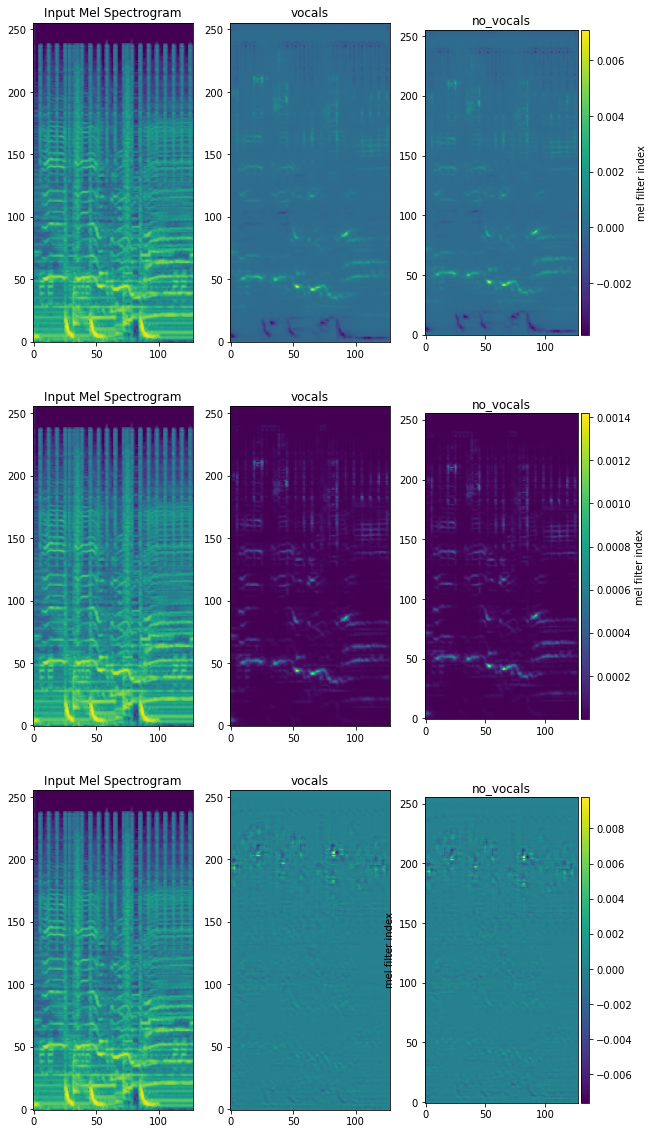

In [22]:
fig, axs = plt.subplots(3, 3, constrained_layout=False, figsize=(10, 20))

plot_explanations(fig, axs[0], inputs, explanations["lrp.sequential_preset_a"])
plot_explanations(fig, axs[1], inputs, explanations["lrp.alpha_1_beta_0_IB"])
plot_explanations(fig, axs[2], inputs, explanations["gradient"])
plt.savefig("saliencymaps comp", dpi =300)


In [100]:
t_dt_voc = np.array(explanations["lrp.sequential_preset_a"][0])
t_dt_voc = np.clip(
    t_dt_voc,
    a_min=1e-15,
    a_max=40
)

t_lrp_a_voc = np.array(explanations["lrp.sequential_preset_a_flat"][0])
t_lrp_a_voc = np.clip(
    t_lrp_a_voc,
    a_min=1e-15,
    a_max=40
)

t_lrp_b_voc = np.array(explanations["lrp.alpha_1_beta_0_IB"][0])
t_lrp_b_voc = np.clip(
    t_lrp_b_voc,
    a_min=1e-15,
    a_max=40
)


t_lrp_a1b0_voc = np.array(explanations["lrp.alpha_1_beta_0"])
t_lrp_a1b0_voc = np.clip(
    t_lrp_a1b0_voc,
    a_min=1e-15,
    a_max=40
)

t_lrp_e_voc = np.array(explanations["lrp.alpha_2_beta_1_IB"][0])
t_lrp_e_voc = np.clip(
    t_lrp_e_voc,
    a_min=1e-15,
    a_max=40
)


t_lrp_f_voc = np.array(explanations["lrp.flat"][0])
t_lrp_f_voc = np.clip(
    t_lrp_f_voc,
    a_min=1e-15,
    a_max=40
)

#salience_voc = t_dt_voc     #not bad
#salience_voc = t_lrp_a_voc   
#salience_voc = t_lrp_b_voc
salience_voc = t_lrp_a1b0_voc  #not bad
#salience_voc = t_lrp_e_voc
#salience_voc = t_lrp_f_voc

In [101]:
"""t_dt_acc = np.array(explanations_acc["deep_taylor"])
t_dt_acc = np.clip(
    t_dt_acc,
    a_min=1e-15,
    a_max=40
)
 
t_lrp_a_acc = np.array(explanations_acc["lrp.sequential_preset_a"])
t_lrp_a_acc = np.clip(
    t_lrp_a_acc,
    a_min=1e-15,
    a_max=40
)
"""
t_lrp_b_acc = np.array(explanations["lrp.alpha_1_beta_0"][1])
t_lrp_b_acc = np.clip(
    t_lrp_b_acc,
    a_min=1e-15,
    a_max=40
)

"""
t_lrp_z_acc = np.array(explanations_acc["lrp.z"])
t_lrp_z_acc = np.clip(
    t_lrp_z_acc,
    a_min=1e-15,
    a_max=40
)

t_lrp_e_acc = np.array(explanations_acc["lrp.epsilon"])
t_lrp_e_acc = np.clip(
    t_lrp_e_acc,
    a_min=1e-15,
    a_max=40
)


t_lrp_f_acc = np.array(explanations_acc["lrp.flat"])
t_lrp_f_acc = np.clip(
    t_lrp_f_acc,
    a_min=1e-15,
    a_max=40
)"""


#salience_acc = t_dt_acc
#salience_acc = t_lrp_a_acc
salience_acc = t_lrp_b_acc
#salience_acc = t_lrp_z_acc  #not bad
#salience_acc = t_lrp_e_acc
#salience_acc = t_lrp_f_acc

In [19]:
salience_voc[0].shape

(10, 128, 256)

## Mask vocals

In [102]:
#Apply Sigmoid
mask_voc = scipy.special.expit(salience_voc[0])
#Normalize mask
mask_voc = np.log10(0.01+mask_voc)
mask_voc = (mask_voc - mask_voc.min()) / (mask_voc.max() - mask_voc.min())
mask_voc.shape

(8, 128, 256)

## Mask accompaniment

In [103]:
#it should be the inverse of mask_voc
mask_acc = 1-mask_voc

In [114]:
#mask_acc = scipy.special.expit(mask_acc)
#mask_acc = np.log10(0.01+mask_acc)
#mask_acc = (mask_acc - mask_acc.min()) / (mask_acc.max() - mask_acc.min())

In [103]:
"""#Apply Sigmoid
mask_acc = scipy.special.expit(salience_acc)

#Normalize mask
mask_acc = np.log10(0.01+mask_acc)
mask_acc = (mask_acc - mask_acc.min()) / (mask_acc.max() - mask_acc.min())
mask_acc.shape"""

(9, 128, 256)

In [17]:
#Different masking method
#eps = 1.0
#while eps + 1 > 1:
#    eps /= 2
#eps *= 2
#mask_acc1 = mask_acc/(mask_voc+mask_acc+eps)
#mask_voc1 = mask_voc/(mask_voc+mask_acc+eps)

# Find original phase and full spectrogram

In [207]:
FE = FeatureExtractor()
file_name = dataset.file_lists['test'][instance]
#file_name = dataset.file_lists['train'][instance]
y = FE.load_audio(file_name, mono=True, change_sampling_rate=False)

ms = MelSpectrogram(**params_features, full_spectrogram=False)

msf = MelSpectrogram(**params_features, full_spectrogram=True)

mel = ms.calculate(file_name)
melorig = msf.calculate(file_name)

features = STFT_Phase(**params_features, full_spectrogram=False)
phase = features.calculate(file_name)
#phase = np.concatenate(phase, axis=0)

print('Phase shape:', phase.shape)
#print('Phase shape:', phase.shape)


Phase shape: (8, 128, 2049)


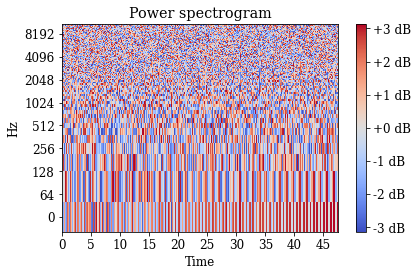

In [208]:
import matplotlib.pyplot as plt
librosa.display.specshow(phase[0],
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# OVERLAP ADD FOR SPEC AND SIGNAL

In [209]:
def overlapaddspec(speech, time_context, overlap, orig):
    sep1 = np.zeros(((len(speech)*(time_context-overlap)+time_context), int(speech.shape[-1])))
    window = np.linspace(0., 1.0, num=overlap)
    window = np.concatenate((window,window[::-1]))
    window = np.repeat(np.expand_dims(window, axis=1), int(speech.shape[-1]), axis=1)
    i=0
    start=0

    for sig in speech:
        s1=sig
        #print(start)
        #plt.imshow(s1)
        if start==0:
            sep1[0:time_context] = s1
        if i == len(speech)-1:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
            sep = sep1[0:len(orig)]
        else:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        i = i + 1 #index for each block
        start = start - overlap + time_context
    return sep

In [156]:
time_context_spec = features.sequence_frames
overlap_spec = features.sequence_frames/2

In [215]:
maskv = overlapaddspec(mask_voc, time_context_spec, overlap_spec, melorig)
maska = overlapaddspec(mask_acc, time_context_spec, overlap_spec, melorig)
original = overlapaddspec(X[instance], time_context_spec, overlap_spec, melorig)
mels = overlapaddspec(mel, time_context_spec, overlap_spec, melorig)

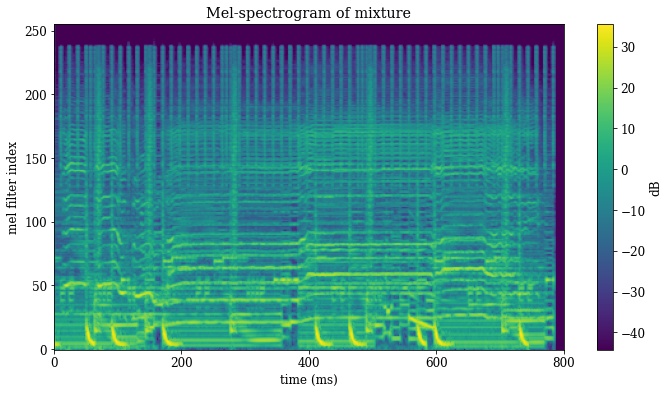

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))
#m = melorig.T
plt.imshow(melorig.T)
cbar = plt.colorbar()
cbar.set_label('dB')
#fig.colorbar(cax).set_label('Intensity [dB]')
plt.gca().invert_yaxis()
t = plt.xticks()
ticks = t[0][1:len(t[0])-1]
labels = [int(i*2) for i in ticks]
plt.xlim(0,400)
plt.xticks(ticks=ticks, labels=labels)
plt.title('Mel-spectrogram of mixture')
plt.xlabel('time (ms)')
plt.ylabel('mel filter index')
plt.savefig('full_spec_.png', dpi=300 )

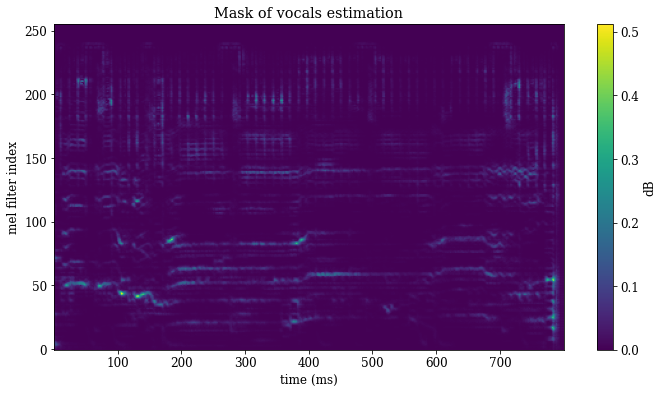

In [242]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(maskv.T)
cbar = plt.colorbar()
cbar.set_label('dB')
#fig.colorbar(cax).set_label('Intensity [dB]')
plt.gca().invert_yaxis()
plt.xlim(0,400)
t = plt.xticks()
ticks = t[0][1:len(t[0])-1]
labels = [int(i*2) for i in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.title('Mask of vocals estimation')
plt.xlabel('time (ms)')
plt.ylabel('mel filter index')
plt.savefig('saliency_mask_full.png', dpi=300)

# RECONSTRUCTION

In [17]:
def save_audio_to_file(x, sample_rate, outfile='out.wav'):
    """Save a mono signal to a file.
    Args:
        x (1-dim Numpy array): The audio signal to save. The signal values should be in the range [-1.0, 1.0].
        sample_rate (int): The sample rate of the signal, in Hz.
        outfile: Name of the file to save.
    """
    x_max = np.max(abs(x))
    #assert x_max <= 1.0, 'Input audio value is out of range. Should be in the range [-1.0, 1.0].'
    x = x*32767.0
    data = array.array('h')
    for i in range(len(x)):
        cur_samp = int(round(x[i]))
        data.append(cur_samp)
    f = wave.open(outfile, 'w')
    f.setparams((1, 2, sample_rate, 0, "NONE", "Uncompressed"))
    f.writeframes(data.tostring())
    f.close()

In [18]:
# play audio file. If list, play all audio files
def play_audio(path_of_wav):
    if isinstance(path_of_wav, list):
        for item in path_of_wav:
            display(Audio(item))
    else:
        display(Audio(path_of_wav))

In [29]:
FE = FeatureExtractor()
specpath = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures3/features/MelSpectrogram/original/test/' + dataset.file_lists['test'][506].split('/')[-1].replace('.wav', '.npy')
file_name = dataset.file_lists['test'][506]
#file_name = dataset.file_lists['train'][instance]
y = FE.load_audio(file_name, mono=True, change_sampling_rate=False)

ms = MelSpectrogram(**params_features, full_spectrogram=False)

msf = MelSpectrogram(**params_features, full_spectrogram=True)

mel = ms.calculate(file_name)
melorig = msf.calculate(file_name)

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/feature_extractor.py:358: FutureWarning: Pass size=724992 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode=self.pad_mode
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/dcase_models/data/features.py:322: FutureWarning: Pass size=837 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  axis=0, mode='constant')


In [38]:
time_context_spec = features.sequence_frames
overlap_spec = int(features.sequence_frames/2)

In [31]:
original = overlapaddspec(X[506], time_context_spec, overlap_spec, melorig)
mels = overlapaddspec(mel, time_context_spec, overlap_spec, melorig)

# PLOT MEL SPEC OF MIXTURE

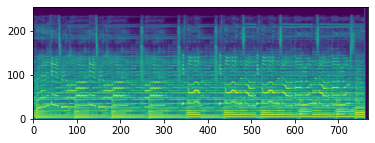

In [24]:
specpath = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures/features/MelSpectrogram/original/test/' + dataset.file_lists['test'][506].split('/')[-1].replace('.wav', '.npy')

spec = np.load(specpath)
plt.subplot(1,1,1)
plt.imshow(np.concatenate(spec, axis=0).T, origin='lower')

# PLOT MEL SPECTROGRAMS OF VOCALS AND ACCOMPANIMENT

/home/christosf/AttProtos/datasets/MUSDB18Mixtures3/groundtruth/Mu - Too Bright_vocaltrack_9/Mu - Too Bright_vocaltrack_9.wav
/home/christosf/AttProtos/datasets/MUSDB18Mixtures/acctracks/test/Mu - Too Bright_acctrack_9.wav


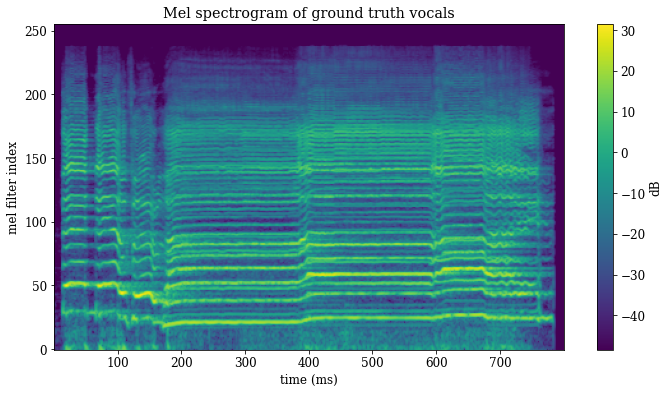

In [256]:
FE = FeatureExtractor()
path1 = "/home/christosf/AttProtos/datasets/MUSDB18Mixtures3/groundtruth/"
path2 = "/home/christosf/AttProtos/datasets/MUSDB18Mixtures/acctracks/test/"
voc = dataset.file_lists['test'][instance].split('/')[-1]
vocaltrack = voc.replace('vocals', 'vocaltrack')
acc = dataset.file_lists['test'][instance].split('/')[-1]
acctrack = acc.replace('vocals', 'acctrack')
#vocaltrackpath = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures/vocaltracks/test/Speak Softly - Like Horses_vocaltrack_4.wav'
vocaltrackpath =  path1 + vocaltrack.split('.wav')[0] + '/' + vocaltrack
print(vocaltrackpath)
#acctrackpath = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures/acctracks/test/Speak Softly - Like Horses_acctrack_4.wav'
acctrackpath = path2 + acctrack
print(acctrackpath)
#yv = FE.load_audio(vocaltrack, mono=False, change_sampling_rate=False)
#ya = FE.load_audio(acctrack, mono=False, change_sampling_rate=False)

mel = MelSpectrogram(**params_features, full_spectrogram=False)
melvocal = mel.calculate(vocaltrackpath)
melacc = mel.calculate(acctrackpath)

fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(overlapaddspec(melvocal, time_context_spec, overlap_spec, melorig).T, origin='lower')
plt.title('Mel spectrogram of ground truth vocals')
cbar = plt.colorbar()
cbar.set_label('dB')
#fig.colorbar(cax).set_label('Intensity [dB]')
#plt.gca().invert_yaxis()
plt.xlim(0,400)
t = plt.xticks()
ticks = t[0][1:len(t[0])-1]
labels = [int(i*2) for i in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('time (ms)')
plt.ylabel('mel filter index')
plt.savefig('groundtruthvocals.png', dpi=300)

/home/christosf/AttProtos/datasets/MUSDB18Mixtures/vocaltracks/test/Speak Softly - Like Horses_vocaltrack_19.wav
/home/christosf/AttProtos/datasets/MUSDB18Mixtures/acctracks/test/Speak Softly - Like Horses_acctrack_19.wav


Text(0, 0.5, 'mel filter index')

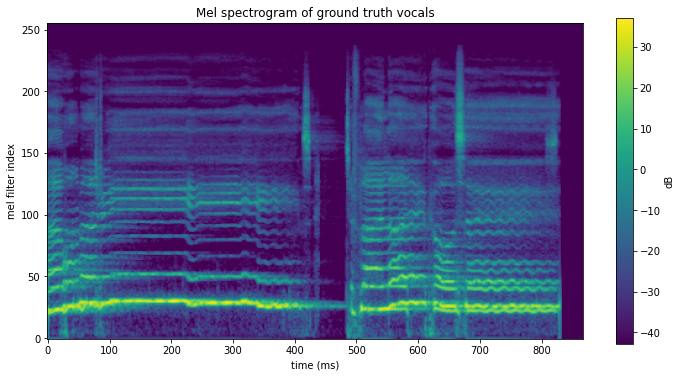

In [371]:
FE = FeatureExtractor()
path1 = "/home/christosf/AttProtos/datasets/MUSDB18Mixtures/vocaltracks/test/"
path2 = "/home/christosf/AttProtos/datasets/MUSDB18Mixtures/acctracks/test/"
voc = dataset.file_lists['test'][instance].split('/')[-1]
vocaltrack = voc.replace('vocals', 'vocaltrack')
acc = dataset.file_lists['test'][instance].split('/')[-1]
acctrack = acc.replace('vocals', 'acctrack')
#vocaltrackpath = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures/vocaltracks/test/Speak Softly - Like Horses_vocaltrack_4.wav'
vocaltrackpath =  path1 + vocaltrack
print(vocaltrackpath)
#acctrackpath = '/home/christosf/AttProtos/datasets/MUSDB18Mixtures/acctracks/test/Speak Softly - Like Horses_acctrack_4.wav'
acctrackpath = path2 + acctrack
print(acctrackpath)
#yv = FE.load_audio(vocaltrack, mono=False, change_sampling_rate=False)
#ya = FE.load_audio(acctrack, mono=False, change_sampling_rate=False)

mel = MelSpectrogram(**params_features, full_spectrogram=False)
melvocal = mel.calculate(vocaltrackpath)
melacc = mel.calculate(acctrackpath)

fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(overlapaddspec(melvocal, time_context_spec, overlap_spec, melorig).T, origin='lower')
plt.title('Mel spectrogram of ground truth vocals')
cbar = plt.colorbar()
cbar.set_label('dB')
#fig.colorbar(cax).set_label('Intensity [dB]')
#plt.gca().invert_yaxis()
t = plt.xticks()
ticks = t[0][1:len(t[0])-1]
labels = [int(i*2) for i in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('time (ms)')
plt.ylabel('mel filter index')

Text(0, 0.5, 'mel filter index')

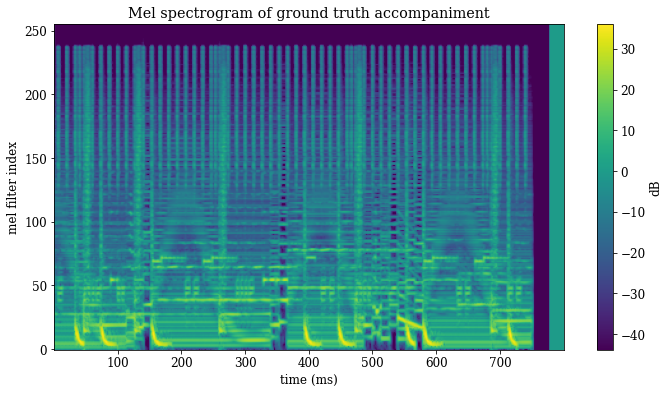

In [258]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.imshow(overlapaddspec(melacc,  time_context_spec, overlap_spec, melorig).T, origin='lower')
plt.title('Mel spectrogram of ground truth accompaniment')

cbar = plt.colorbar()
cbar.set_label('dB')
#fig.colorbar(cax).set_label('Intensity [dB]')
#plt.gca().invert_yaxis()
plt.xlim(0,400)

t = plt.xticks()
ticks = t[0][1:len(t[0])-1]
labels = [int(i*2) for i in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('time (ms)')
plt.ylabel('mel filter index')

# APPLY MASK AND RECONSTRUCT

In [198]:
def overlapadd(speech, time_context, overlap, y):
    sep1 = np.zeros((((len(speech)*(time_context-overlap)+time_context), )))
    window = np.linspace(0., 1.0, num=overlap)
    window = np.concatenate((window,window[::-1]))
    #window = np.expand_dims(window, axis=1)
    i=0
    start=0

    for sig in speech:
        s1=sig
        if start==0:
            sep1[0:time_context] = s1
            sep1[0:overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        if i == len(speech)-1:
            #print(start)
            #diff = len(s1[overlap:time_context])-len(sep1[start+overlap:start+time_context])
            #print(diff)
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
            sep=sep1[0:len(y)]
        else:
            sep1[start+overlap:start+time_context] = s1[overlap:time_context]
            sep1[start:start+overlap] = window[overlap:]*sep1[start:start+overlap] + window[:overlap]*s1[:overlap]
        i = i + 1 #index for each block
        start = start - overlap + time_context
    return sep

In [193]:
#instance = 506
speech = []
inverse_vocs = []
for i in range(len(X[instance])):
#for frame in audio_representation:
    scaled = X[instance][i]
    #scaled = frame
    inversed = scaler.inverse_transform(scaled.T)
    melspec = librosa.db_to_power(inversed)
    #print(melspec)
    masked_spec_voc = melspec*mask_voc[i].T
    inverse_voc = nnls(features.mel_basis, masked_spec_voc)
    inverse_voc = np.power(inverse_voc, 1./2.0, out=inverse_voc)
    #print(inverse_voc)
    inverse_vocs.append(inverse_voc)
    #mag_spec_voc.append(inverse_voc)
    polar_speech = inverse_voc * np.cos(phase[i].T) + inverse_voc * np.sin(phase[i].T) * 1j

    speech_out = librosa.istft(polar_speech, hop_length=features.audio_hop, win_length=features.audio_win, window='hann', center=True)
    
    speech.append(speech_out)
    
    #speech_out = librosa.istft(polar_speech, hop_length=features.audio_hop, win_length=features.audio_win, n_fft=features.n_fft, window='hann', center=False, length=len(y))
    #out = overl(speech_out)
    #print(out.shape)
    #audioout = np.append(audioout, speech_out)
    
#mag_spec_voc = np.concatenate(mag_spec_voc, axis = 1)
#polar_speech = mag_spec_voc * np.cos(phase.T) + mag_spec_voc * np.sin(phase.T) * 1j
#speech_out = librosa.istft(polar_speech, hop_length=features.audio_hop, win_length=features.audio_win, n_fft=features.n_fft, window='hann', center=False)


In [87]:
acc = []
for i in range(6):
#for frame in audio_representation:
    scaled = X[instance][i]
    #scaled = frame
    inversed = scaler.inverse_transform(scaled.T)
    melspec = librosa.db_to_power(inversed)
    masked_spec_acc = melspec*mask_acc[i].T
    inverse_acc = nnls(features.mel_basis, masked_spec_acc)
    inverse_acc = np.power(inverse_acc, 1./2.0, out=inverse_acc)
    #mag_spec_voc.append(inverse_voc)
    polar_acc = inverse_acc * np.cos(phase[i].T) + inverse_acc * np.sin(phase[i].T) * 1j
    acc_out = librosa.istft(polar_acc, hop_length=features.audio_hop, win_length=features.audio_win, n_fft=features.n_fft, window='hann', center=True)
    acc.append(acc_out)

In [194]:
time_context_sig = len(speech[0])
overlap_sig = int(time_context_sig/2) - int(features.audio_hop/2)

In [ ]:
signal = overlapadd(speech, time_context_sig, overlap_sig, y)
accomp = overlapadd(acc, time_context_sig, overlap_sig, y)


sf.write('mix.wav', y, 44100)
play_audio('mix.wav')

sf.write('voc.wav', signal, 44100)
play_audio('voc.wav')

sf.write('acc.wav', accomp, 44100)
play_audio('acc.wav')

# Checking the sample alignment

/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if __name__ == '__main__':
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':
/home/christosf/anaconda3/envs/apnet2/lib/python3.6/site-packages/ipykernel_launcher.py:22: 

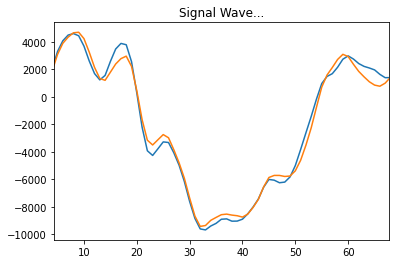

In [61]:
spf = wave.open("voc.wav", "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")

spf2 = wave.open("mix.wav", "r")
orig = spf2.readframes(-1)
orig = np.fromstring(orig, "Int16")
# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

fig, ax1 = plt.subplots() 
plt.title("Signal Wave...")
#plt.plot(signal[time_context_sig+390:time_context_sig+400])
#plt.plot(orig[time_context_sig+390:time_context_sig+400])
plt.plot(signal[300890:300963])
plt.plot(orig[300890:300963])

ax1.xaxis.zoom(1)
plt.show()